In [75]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# TFIDF Matrix w/ summary + review

In [43]:
from scipy.sparse import load_npz
df = pd.read_csv('../../../data/processed/tokenized_data.csv')

tfidf_matrix = load_npz('../../../data/processed/tfidf_matrix.npz')
labels = df['overall'].values

with open('../../../data/processed/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, feature_names, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_classifier.predict(X_test)

In [44]:
# Save model to pickle file
with open ('pickle_model/rf_tfidf_matrix', 'wb') as f:
    pickle.dump(rf_classifier, f)


In [47]:
print(classification_report(y_test, y_pred))
accuracy = rf_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

         1.0       0.67      0.77      0.71     20917
         2.0       0.72      0.35      0.47     12765
         3.0       0.63      0.44      0.52     19019
         4.0       0.66      0.48      0.55     28682
         5.0       0.79      0.94      0.86     88965

    accuracy                           0.74    170348
   macro avg       0.69      0.60      0.62    170348
weighted avg       0.73      0.74      0.72    170348

Accuracy: 0.7405076666588396


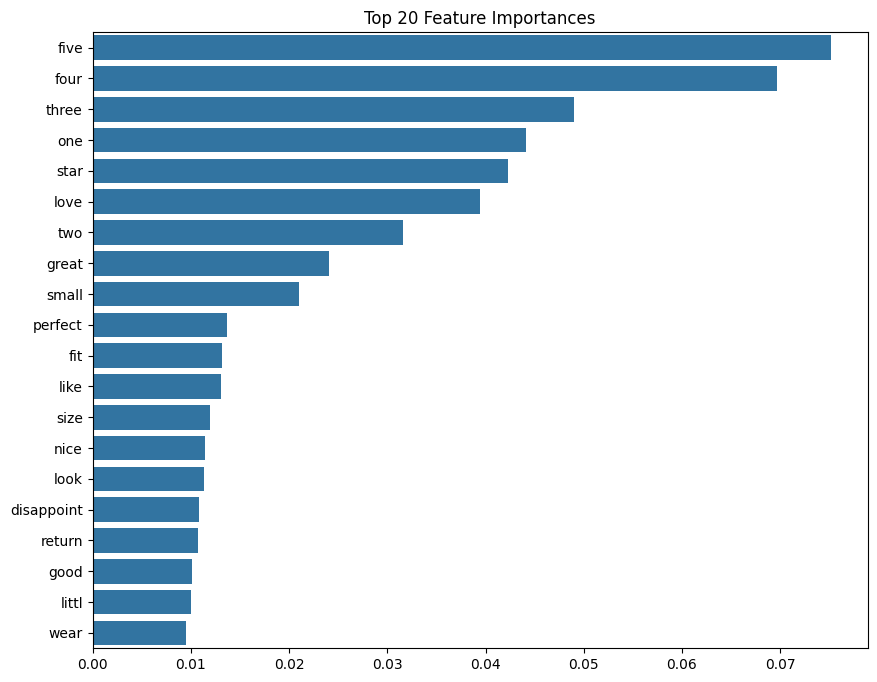

In [50]:
# Get the feature importances
feature_importances = rf_classifier.feature_importances_

# Sort the feature importances in descending order and get the indices of the top 20
indices = np.argsort(feature_importances)[::-1][:20]

# Create labels for the top 20 features with the sorted indices
top_20_feature_names = feature_names[indices]
top_20_feature_importances = feature_importances[indices]

# Plot the top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x=top_20_feature_importances, y=top_20_feature_names)
plt.title('Top 20 Feature Importances')
plt.show()

# TFIDF matrix w/ only reviews

In [79]:
tfidf_matrix_reviewOnly = load_npz('../../../data/processed/tfidf_matrix_reviewOnly.npz')
with open('../../../data/processed/feature_names_100vocab.pkl', 'rb') as f:
    feature_names_100vocab = pickle.load(f)

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_reviewOnly, labels, test_size=0.2, random_state=42)

rf_classifier_reviewOnly = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier_reviewOnly.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_classifier_reviewOnly.predict(X_test)

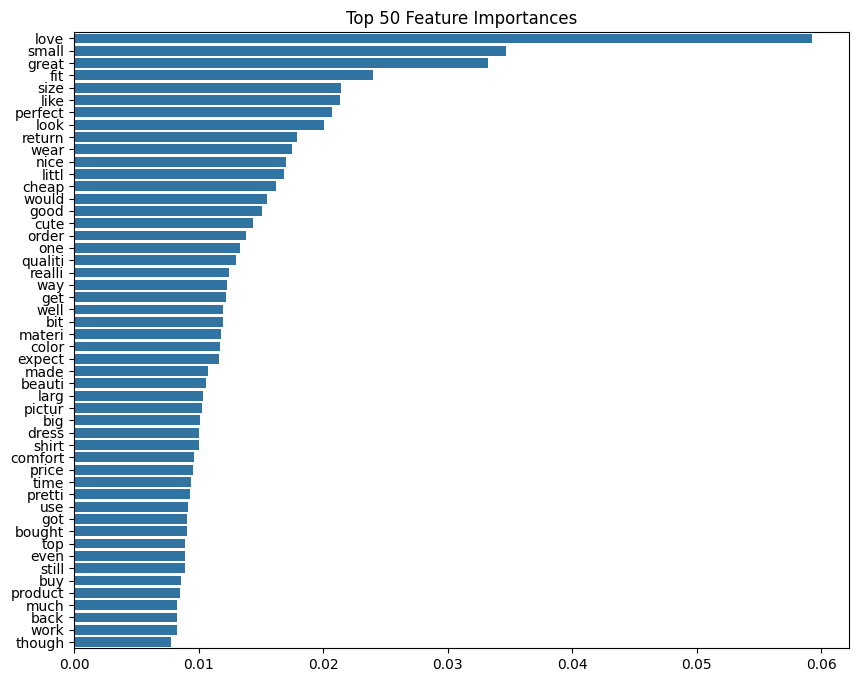

In [81]:
# Get the feature importances
feature_importances_reviewOnly = rf_classifier_reviewOnly.feature_importances_

# Sort the feature importances in descending order and get the indices of the top 20
indices = np.argsort(feature_importances_reviewOnly)[::-1][:50]

# Create labels for the top 20 features with the sorted indices
top_50_feature_names = feature_names_100vocab[indices]
top_50_feature_importances = feature_importances_reviewOnly[indices]

# Plot the top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x=top_50_feature_importances, y=top_50_feature_names)
plt.title('Top 50 Feature Importances')
plt.show()

In [82]:
# Print the classification report
print(classification_report(y_test, y_pred))
# Evaluate the model
accuracy = rf_classifier_reviewOnly.score(X_test, y_test)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

         1.0       0.49      0.56      0.52     20917
         2.0       0.24      0.06      0.10     12765
         3.0       0.30      0.15      0.20     19019
         4.0       0.37      0.18      0.24     28682
         5.0       0.68      0.90      0.77     88965

    accuracy                           0.59    170348
   macro avg       0.41      0.37      0.37    170348
weighted avg       0.53      0.59      0.54    170348

Accuracy: 0.5939488576326108


In [83]:
from sklearn.metrics import mean_squared_error
mse_scores = {}
for star in range(1, 6): 
    # Filter instances of the current class
    indices = np.where(y_test == star)[0]  # Get the array of indices
    X_test_filtered = X_test.iloc[indices] if isinstance(X_test, pd.DataFrame) else X_test[indices]
    y_test_filtered = y_test.iloc[indices] if isinstance(y_test, pd.Series) else y_test[indices]

    # Predict ratings for the filtered instances
    y_pred_filtered = rf_classifier_reviewOnly.predict(X_test_filtered)

    # Calculate MSE for this class
    mse = mean_squared_error(y_test_filtered, y_pred_filtered)
    mse_scores[star] = mse

mse_scores

{1: 5.224410766362289,
 2: 4.002820211515863,
 3: 2.769125611230874,
 4: 1.297956906770797,
 5: 0.5999550384982858}

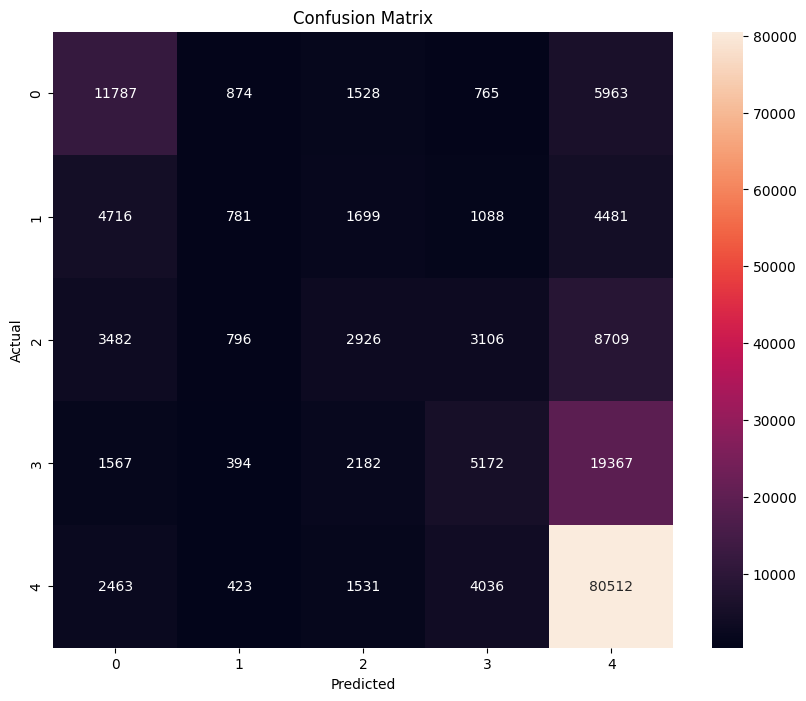

In [61]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Random Forest (w/ Undersampling majority class)

In [64]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the majority class (5-star reviews) automatically
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict the target variable for the test set
y_pred = rf_model.predict(X_test)

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.38      0.59      0.47     20917
         2.0       0.19      0.28      0.22     12765
         3.0       0.24      0.26      0.25     19019
         4.0       0.29      0.38      0.33     28682
         5.0       0.82      0.57      0.67     88965

    accuracy                           0.48    170348
   macro avg       0.38      0.41      0.39    170348
weighted avg       0.57      0.48      0.51    170348



In [66]:
# Display class distribution after undersampling
print("\nClass Distribution After Undersampling:")
print(pd.Series(y_train_resampled).value_counts())


Class Distribution After Undersampling:
1.0    50344
2.0    50344
3.0    50344
4.0    50344
5.0    50344
Name: count, dtype: int64


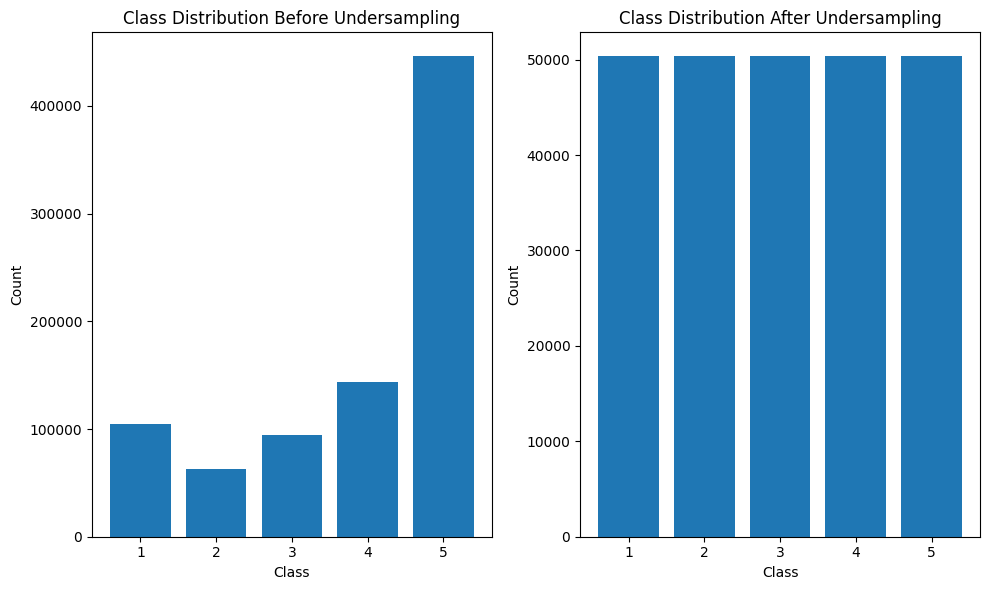

In [67]:
import matplotlib.pyplot as plt

# Plot class distribution before and after undersampling
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('Class Distribution Before Undersampling')
plt.bar(y.value_counts().index, y.value_counts().values)
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.title('Class Distribution After Undersampling')
plt.bar(pd.Series(y_train_resampled).value_counts().index, pd.Series(y_train_resampled).value_counts().values)
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

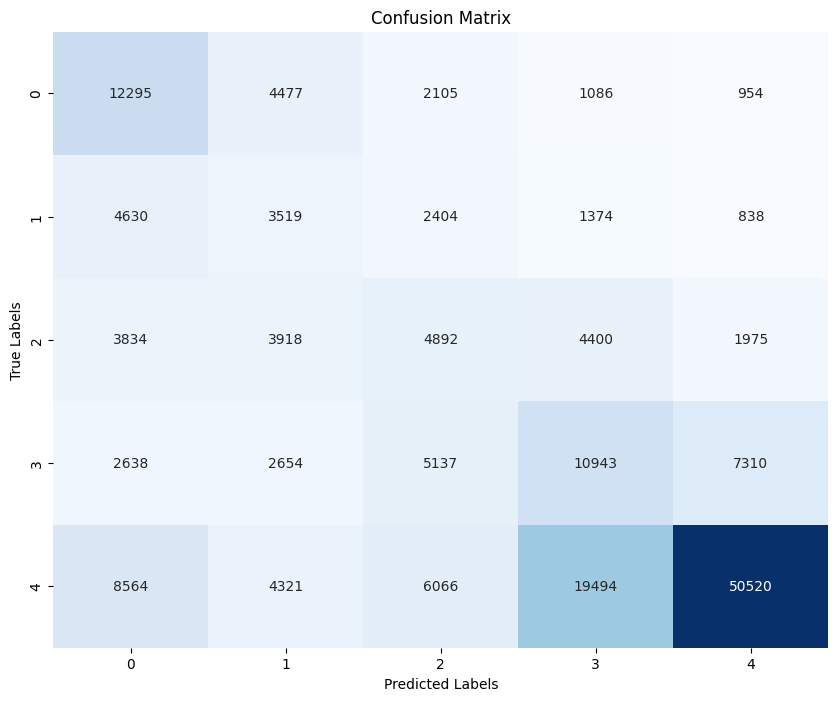

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


c:\Users\emine\anaconda3\envs\ds\lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


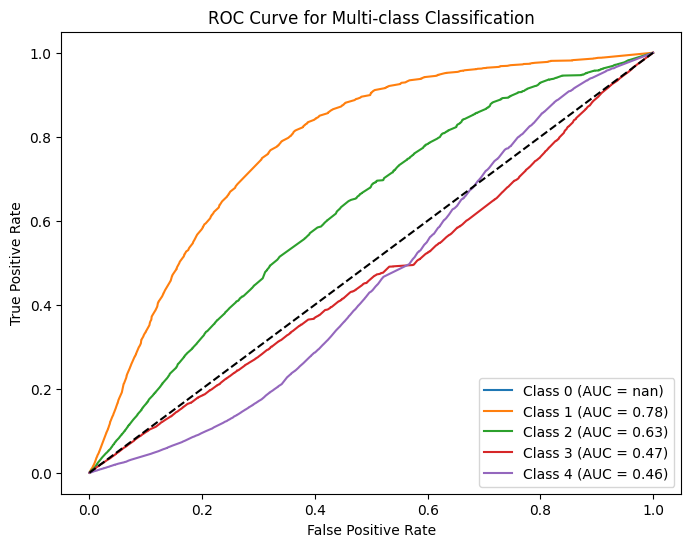

In [68]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = rf_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

In [69]:
mse_scores = {}
for star in range(1, 6): 
    # Filter instances of the current class
    indices = np.where(y_test == star)[0]  # Get the array of indices
    X_test_filtered = X_test.iloc[indices] if isinstance(X_test, pd.DataFrame) else X_test[indices]
    y_test_filtered = y_test.iloc[indices] if isinstance(y_test, pd.Series) else y_test[indices]

    # Predict ratings for the filtered instances
    y_pred_filtered = rf_model.predict(X_test_filtered)

    # Calculate MSE for this class
    mse = mean_squared_error(y_test_filtered, y_pred_filtered)
    mse_scores[star] = mse

mse_scores

{1: 1.813596596070182,
 2: 1.572424598511555,
 3: 1.6590777643409222,
 4: 1.6318597029495852,
 5: 2.4691845107626595}